# Image Classification

In [18]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.svm import SVC
from skimage.transform import resize
from skimage.io import imread
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from skimage.color import rgb2hsv
from skimage.feature import local_binary_pattern
from sklearn.linear_model import SGDClassifier
from skimage.feature import canny
from sklearn.ensemble import RandomForestClassifier

# PART 1

## Preprocessing

กำหนด Path ของ ไฟล์

In [19]:
base_path = 'C:/Users/User/Downloads/Work/ImageReg/garbage_classification/'
categories = ['paper','cardboard','plastic','metal','trash','battery','shoes','clothes','green-glass','brown-glass','white-glass','biological']

สร้าง DataFrame

In [20]:
name_list = []
cat_list = []
im_list = []

for cat in categories:
    name = os.listdir(base_path + cat)
    name = shuffle(name,random_state=69)
    name = ['garbage_classification/'+cat+'/'+i for i in name[:100]]
    name_list+=name
    img = [imread(i) for i in name]
    im_list+=img
    cat_list+=[cat]*len(name)
df = pd.DataFrame({'TrashFile':name_list,'Image':im_list,'Category':cat_list})
df.head()

,TrashFile,Image,Category
0,garbage_classification/paper/paper822.jpg,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",paper
1,garbage_classification/paper/paper853.jpg,"[[[219, 204, 197], [219, 204, 197], [219, 204,...",paper
2,garbage_classification/paper/paper485.jpg,"[[[243, 218, 222], [243, 218, 222], [244, 217,...",paper
3,garbage_classification/paper/paper293.jpg,"[[[93, 107, 90], [78, 92, 75], [70, 83, 66], [...",paper
4,garbage_classification/paper/paper500.jpg,"[[[230, 229, 224], [231, 230, 225], [231, 230,...",paper


เปลี่ยนขนาดของข้อมูลให้เท่ากัน

In [21]:
df.Image = [resize(i,(128,128,3)) for i in df.Image]

แสดงตัวอย่างภาพ

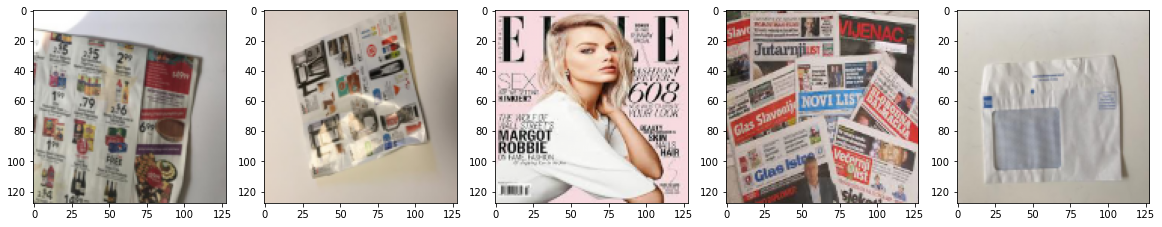

In [22]:
plt.figure(figsize=(20, 10))
for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(df['Image'][i-1]);


กำหนด Training Data และ Testing Data

In [23]:
X = df['Image']
y = df['Category']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=69)

## Feature Extraction

### HOG

แสดงตัวอย่างภาพ HOG

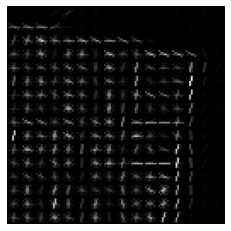

In [24]:
hog_feature, hog_image = hog(df.Image[0], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
plt.axis("off")
plt.imshow(hog_image,cmap='gray');

สร้างฟังก์ชั่นเพื่อใช้หา HOG

In [25]:
def get_hog(img):
    hog_feat = []
    for i in img:
        fd, hog_image = hog(i, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_feat.append(fd)
    new_feat = StandardScaler().fit_transform(hog_feat)
    return new_feat

หา HOG จาก X_train และ X_test

In [26]:
hog_train = get_hog(X_train)
hog_train.shape

(960, 8100)

In [27]:
hog_test = get_hog(X_test)
hog_test.shape

(240, 8100)

### Color Feature

แสดงภาพ HSV

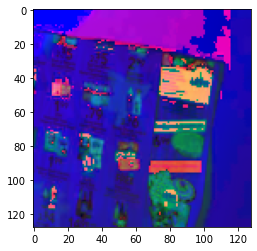

In [68]:
hsv_img = rgb2hsv(df.Image[0])
plt.imshow(hsv_img);

แสดงภาพ hue

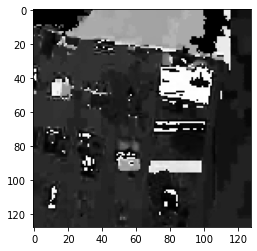

In [69]:
hue_img = hsv_img[:, :, 0]
plt.imshow(hue_img,cmap='gray');

สร้างฟังก์ชั่นหา color feature

In [70]:
def get_color(img):
    hue_feat = []
    for i in img:
        hsv_img = rgb2hsv(i)
        hue_val = hsv_img[:, :, 0].reshape(1,-1)
        hist,bins = np.histogram(hue_val,bins=np.arange(-0.5,256,1))
        hue_feat.append(hist/np.sum(hist))
    hue_feat = np.array(hue_feat)
    return hue_feat

หา HOG จาก X_train และ X_test

In [71]:
hue_train = get_color(X_train)
hue_train.shape

(960, 256)

In [72]:
hue_test = get_color(X_test)
hue_test.shape

(240, 256)

### Concat Feature

In [73]:
new_train = np.concatenate((hog_train,hue_train),axis=1)
new_train.shape

(960, 8356)

In [74]:
new_test = np.concatenate((hog_test,hue_test),axis=1)
new_test.shape

(240, 8356)

## Classification

### KNN

ใช้ Grid Search เพื่อหา Parameter ที่ให้ความแม่นยำสูงสุด

กำหนด Parameters

In [76]:
parameters = {
    'n_neighbors':[3,5,7,9,11,13,15,17,19],
    'weights':('uniform','distance'),
    'algorithm':['ball_tree']}

ใช้ Grid Search เพื่อหา parameter ที่ดีที่สุด

In [77]:
clf = GridSearchCV(KNeighborsClassifier(),param_grid=parameters,scoring='accuracy',cv=5,verbose=3)
clf.fit(new_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END algorithm=ball_tree, n_neighbors=3, weights=uniform;, score=0.177 total time=   2.4s
[CV 2/5] END algorithm=ball_tree, n_neighbors=3, weights=uniform;, score=0.229 total time=   2.4s
[CV 3/5] END algorithm=ball_tree, n_neighbors=3, weights=uniform;, score=0.240 total time=   2.4s
[CV 4/5] END algorithm=ball_tree, n_neighbors=3, weights=uniform;, score=0.214 total time=   2.4s
[CV 5/5] END algorithm=ball_tree, n_neighbors=3, weights=uniform;, score=0.292 total time=   2.5s
[CV 1/5] END algorithm=ball_tree, n_neighbors=3, weights=distance;, score=0.214 total time=   2.4s
[CV 2/5] END algorithm=ball_tree, n_neighbors=3, weights=distance;, score=0.219 total time=   2.4s
[CV 3/5] END algorithm=ball_tree, n_neighbors=3, weights=distance;, score=0.219 total time=   2.4s
[CV 4/5] END algorithm=ball_tree, n_neighbors=3, weights=distance;, score=0.219 total time=   2.3s
[CV 5/5] END algorithm=ball_tree, n_neighbors=3, weig

[CV 4/5] END algorithm=ball_tree, n_neighbors=19, weights=uniform;, score=0.250 total time=   2.4s
[CV 5/5] END algorithm=ball_tree, n_neighbors=19, weights=uniform;, score=0.240 total time=   2.3s
[CV 1/5] END algorithm=ball_tree, n_neighbors=19, weights=distance;, score=0.198 total time=   2.3s
[CV 2/5] END algorithm=ball_tree, n_neighbors=19, weights=distance;, score=0.224 total time=   2.3s
[CV 3/5] END algorithm=ball_tree, n_neighbors=19, weights=distance;, score=0.260 total time=   2.3s
[CV 4/5] END algorithm=ball_tree, n_neighbors=19, weights=distance;, score=0.260 total time=   2.3s
[CV 5/5] END algorithm=ball_tree, n_neighbors=19, weights=distance;, score=0.250 total time=   2.3s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=3)

แสดง parameter และ score ที่ดีที่สุด

In [79]:
print(clf.best_params_)
print(clf.best_score_)

{'algorithm': 'ball_tree', 'n_neighbors': 15, 'weights': 'distance'}
0.24583333333333335


นำ parameter ที่ได้มาสร้าง model ใหม่

In [80]:
knn = KNeighborsClassifier(n_neighbors=15,weights='distance',algorithm='ball_tree')
knn.fit(new_train,y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=15, weights='distance')

แสดง accuracy ของ model

In [81]:
score = accuracy_score(y_test,knn.predict(new_test))
print('Accuracy = '+str(score*100))

Accuracy = 27.083333333333332


### Gaussian Naive Bayes

กำหนด Parameters

In [82]:
parameters = {
    'var_smoothing':[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]}

ใช้ Grid Search เพื่อหา parameter ที่ดีที่สุด

In [83]:
clf1 = GridSearchCV(GaussianNB(),param_grid=parameters,scoring='accuracy',cv=5,verbose=3)
clf1.fit(new_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...............var_smoothing=1e-06;, score=0.302 total time=   0.4s
[CV 2/5] END ...............var_smoothing=1e-06;, score=0.302 total time=   0.4s
[CV 3/5] END ...............var_smoothing=1e-06;, score=0.276 total time=   0.4s
[CV 4/5] END ...............var_smoothing=1e-06;, score=0.297 total time=   0.4s
[CV 5/5] END ...............var_smoothing=1e-06;, score=0.281 total time=   0.4s
[CV 1/5] END ...............var_smoothing=1e-05;, score=0.302 total time=   0.4s
[CV 2/5] END ...............var_smoothing=1e-05;, score=0.302 total time=   0.4s
[CV 3/5] END ...............var_smoothing=1e-05;, score=0.276 total time=   0.4s
[CV 4/5] END ...............var_smoothing=1e-05;, score=0.297 total time=   0.4s
[CV 5/5] END ...............var_smoothing=1e-05;, score=0.281 total time=   0.4s
[CV 1/5] END ..............var_smoothing=0.0001;, score=0.302 total time=   0.4s
[CV 2/5] END ..............var_smoothing=0.0001;,

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                           0.1, 1]},
             scoring='accuracy', verbose=3)

แสดง parameter และ score ที่ดีที่สุด

In [84]:
print(clf1.best_params_)
print(clf1.best_score_)

{'var_smoothing': 1e-06}
0.29166666666666663


นำ parameter ที่ได้มาสร้าง model ใหม่ และหาค่าความแม่นยำ

In [85]:
gnb = GaussianNB(var_smoothing=1e-6)
gnb.fit(new_train,y_train)
score = accuracy_score(y_test,gnb.predict(new_test))
print('Accuracy = '+str(score*100))

Accuracy = 31.666666666666664


### Support Vector Machine

กำหนด Parameters

In [86]:
parameters = {
    'C':[0.0001,0.001,0.01,0.1,1],
    'kernel':['linear','poly','rbf','sigmoid']}

ใช้ Grid Search เพื่อหา parameter ที่ดีที่สุด

In [87]:
clf2 = GridSearchCV(SVC(),param_grid=parameters,scoring='accuracy',cv=5,verbose=3)
clf2.fit(new_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...........C=0.0001, kernel=linear;, score=0.307 total time=   5.3s
[CV 2/5] END ...........C=0.0001, kernel=linear;, score=0.359 total time=   4.9s
[CV 3/5] END ...........C=0.0001, kernel=linear;, score=0.344 total time=   4.2s
[CV 4/5] END ...........C=0.0001, kernel=linear;, score=0.323 total time=   4.2s
[CV 5/5] END ...........C=0.0001, kernel=linear;, score=0.344 total time=   5.0s
[CV 1/5] END .............C=0.0001, kernel=poly;, score=0.094 total time=   4.7s
[CV 2/5] END .............C=0.0001, kernel=poly;, score=0.089 total time=   4.7s
[CV 3/5] END .............C=0.0001, kernel=poly;, score=0.089 total time=   4.7s
[CV 4/5] END .............C=0.0001, kernel=poly;, score=0.094 total time=   4.8s
[CV 5/5] END .............C=0.0001, kernel=poly;, score=0.094 total time=   4.8s
[CV 1/5] END ..............C=0.0001, kernel=rbf;, score=0.094 total time=   7.3s
[CV 2/5] END ..............C=0.0001, kernel=rbf

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=3)

แสดง parameter และ score ที่ดีที่สุด

In [89]:
print(clf2.best_params_)
print(clf2.best_score_)

{'C': 1, 'kernel': 'rbf'}
0.353125


นำ parameter ที่ได้มาสร้าง model ใหม่ และหาค่าความแม่นยำ

In [91]:
svm = SVC(C=1,kernel='rbf')
svm.fit(new_train,y_train)
score = accuracy_score(y_test,svm.predict(new_test))
print('Accuracy = '+str(score*100))

Accuracy = 34.583333333333336


# PART 2

flatten ภาพเพื่อนำมาใช้ในการทำ classification

In [101]:
flat_train = np.array([i.flatten() for i in X_train])
flat_train.shape

(960, 49152)

In [103]:
flat_test = np.array([i.flatten() for i in X_test])
flat_test.shape

(240, 49152)

### Local Binary Pattern

แสดงตัวอย่างภาพ Local Binary Pattern

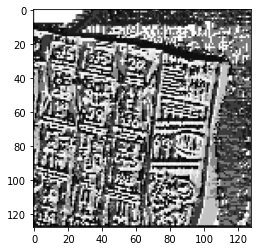

In [104]:
radius = 3
n_points = radius*8
lbp_image = local_binary_pattern(rgb2gray(df.Image[0]),8,1)
plt.imshow(lbp_image,cmap='gray');

สร้างฟังก์ชั่นเพื่อใช้หา LBP

In [105]:
def get_lbp(img):
    radius = 3
    n_points = radius*8
    lbp_feat = []
    
    for i in img:
        gray_img = rgb2gray(i)
        lbp_image = local_binary_pattern(gray_img,8,1)
        n_bins = 9
        hist,bins = np.histogram(lbp_image, density=True, bins=np.arange(2**8 + 1), range=(0, n_bins))
        lbp_feat.append(hist)
    lbp_feat = np.array(lbp_feat)
    return lbp_feat

หา LBP จาก X_train และ X_test

In [106]:
lbp_train = get_lbp(X_train)
lbp_train.shape

(960, 256)

In [107]:
lbp_test = get_lbp(X_test)
lbp_test.shape

(240, 256)

### Concat Feature

In [108]:
new_X_train = np.concatenate((flat_train,hog_train,hue_train,lbp_train),axis=1)
new_X_train.shape

(960, 57764)

In [109]:
new_X_test = np.concatenate((flat_test,hog_test,hue_test,lbp_test),axis=1)
new_X_test.shape

(240, 57764)

### Random Forest Classifier

กำหนด Parameters

In [110]:
parameters = {
    'n_estimators':[100,1000],
    'criterion':['gini'],
    'min_samples_split':[2,3,4],
    'random_state':[69]}

ใช้ Grid Search เพื่อหา parameter ที่ดีที่สุด

In [111]:
clf3 = GridSearchCV(RandomForestClassifier(),param_grid=parameters,scoring='accuracy',cv=5,verbose=3)
clf3.fit(new_X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END criterion=gini, min_samples_split=2, n_estimators=100, random_state=69;, score=0.479 total time=  10.9s
[CV 2/5] END criterion=gini, min_samples_split=2, n_estimators=100, random_state=69;, score=0.562 total time=  12.8s
[CV 3/5] END criterion=gini, min_samples_split=2, n_estimators=100, random_state=69;, score=0.401 total time=  11.2s
[CV 4/5] END criterion=gini, min_samples_split=2, n_estimators=100, random_state=69;, score=0.547 total time=  10.5s
[CV 5/5] END criterion=gini, min_samples_split=2, n_estimators=100, random_state=69;, score=0.557 total time=  10.1s
[CV 1/5] END criterion=gini, min_samples_split=2, n_estimators=1000, random_state=69;, score=0.531 total time= 1.7min
[CV 2/5] END criterion=gini, min_samples_split=2, n_estimators=1000, random_state=69;, score=0.615 total time= 1.7min
[CV 3/5] END criterion=gini, min_samples_split=2, n_estimators=1000, random_state=69;, score=0.417 total time= 1.6min
[

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 1000], 'random_state': [69]},
             scoring='accuracy', verbose=3)

แสดง parameter และ score ที่ดีที่สุด

In [112]:
print(clf3.best_params_)
print(clf3.best_score_)

{'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 69}
0.5364583333333334


สร้างโมเดล RandomForest

In [113]:
rfc = RandomForestClassifier(criterion='gini', min_samples_split=2, n_estimators=1000,random_state=69)
rfc.fit(new_X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=69)

หาค่า accuracy ของโมเดล RandomForest

In [114]:
score = accuracy_score(y_test,rfc.predict(new_X_test))
print('Accuracy = '+str(score*100))

Accuracy = 52.916666666666664
